### Semi Gradient  SARSA($\lambda $)

In this notebook, we will be using SARSA($\lambda$) with function approximation using Tiles to solve Mountain Car Environment. We will look at couple of eligibility traces. By setting trace to None, it will work same as the previous n-step SARSA. Further, by setting lambda = 0, we will get TD(0) SARSA

![nStepSARSA](./images/nstepSarsa.png "n-Step SARSA")

In [1]:
# Initial imports and environment setup
import gymnasium as gym
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

### Mountain Car Environment

Mountain Car Environment


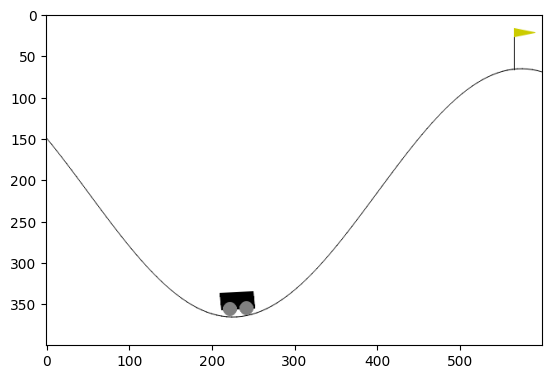

In [2]:
env = gym.make('MountainCar-v0', render_mode="rgb_array") # rest of the code is designed to work only for this environment. It will require change for other environments

# increase episode length from 200 to 4000
env._max_episode_steps = 4000

np.random.seed(13)
env.reset()
print("Mountain Car Environment")
plt.imshow(env.render())

### The Agent

In [3]:
# the implementation of tiles3 is from Richard Sutton's website
# http://incompleteideas.net/tiles/tiles3.html
from tiles3 import IHT, tiles

In [4]:
def accumulating_trace(trace, active_features, gamma, lambd):
    trace *= gamma * lambd
    trace[active_features] += 1
    return trace

def replacing_trace(trace, active_features, gamma, lambd):
    trace *= gamma * lambd
    trace[active_features] = 1
    return trace

class QEstimator:

    def __init__(self, step_size, num_of_tilings=8, tiles_per_dim=8, 
                 max_size=2048, epsilon=0.0, trace_fn=replacing_trace, 
                 lambd=0, gamma=1.0):
        
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.tiles_per_dim = tiles_per_dim
        self.epsilon = epsilon
        self.lambd = lambd
        self.gamma = gamma
        
        self.step_size = step_size / num_of_tilings
        self.trace_fn = trace_fn
        
        self.table = IHT(max_size)
        
        self.w = np.zeros(max_size)
        self.trace = np.zeros(max_size)
        
        self.pos_scale = self.tiles_per_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.vel_scale = self.tiles_per_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def get_active_features(self, state, action):
        pos, vel = state
        active_features = tiles(self.table, self.num_of_tilings,
                            [self.pos_scale * (pos - env.observation_space.low[0]), 
                             self.vel_scale * (vel- env.observation_space.low[1])],
                            [action])
        return active_features
        
    def q_predict(self, state, action):
        pos, vel = state
        if pos == env.observation_space.high[0]:  # reached goal
            return 0.0
        else:
            active_features = self.get_active_features(state, action)
            return np.sum(self.w[active_features])
        
    
    # learn with given state, action and target
    def q_update(self, state, action, reward, next_state, next_action):

        active_features = self.get_active_features(state, action)

        q_s_a = self.q_predict(state, action)
        target = reward + self.gamma * self.q_predict(next_state, next_action)
        delta = (target - q_s_a)

        if self.trace_fn == accumulating_trace or self.trace_fn == replacing_trace:
            self.trace = self.trace_fn(self.trace, active_features, self.gamma, self.lambd)
        else:
            self.trace = self.trace_fn(self.trace, active_features, self.gamma, 0)
                
        self.w += self.step_size * delta * self.trace        
        #self.w += self.step_size * delta * self.trace        
        
    def get_eps_greedy_action(self, state):
        pos, vel = state
        if np.random.rand() < self.epsilon:
            return np.random.choice(env.action_space.n)
        else:
            qvals = np.array([self.q_predict(state, action) for action in range(env.action_space.n)])
            return np.argmax(qvals)

    def get_action(self, state):
        pos, vel = state
        qvals = np.array([self.q_predict(state, action) for action in range(env.action_space.n)])
        return np.argmax(qvals) 

### SARSA $\lambda$ Rewards

In [5]:
def sarsa_lambda(qhat, episode_cnt = 10000, max_size=2048, gamma=1.0):
    episode_rewards = []
    for i in range(episode_cnt):
        state, _ = env.reset()
        action = qhat.get_eps_greedy_action(state)
        qhat.trace = np.zeros(max_size)
        episode_reward = 0
        while True:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = qhat.get_eps_greedy_action(next_state)
            episode_reward += reward
            qhat.q_update(state, action, reward, next_state, next_action)
            if terminated:
                episode_rewards.append(episode_reward)
                break
            state = next_state   
            action = next_action
    return np.array(episode_rewards)
    

### Per Episode Returns

In [6]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean Return/episode = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.xlabel("Episode number")
    plt.ylabel("Return per episode")
    plt.show()

### Recording Video of Agent

In [7]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])    
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()    
    for _ in range(video_length + 1):
        action = agent.get_action(obs[0])
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]   
    # Save the video
    vec_env.close()
    return file_path

### Train Agent and plot returns

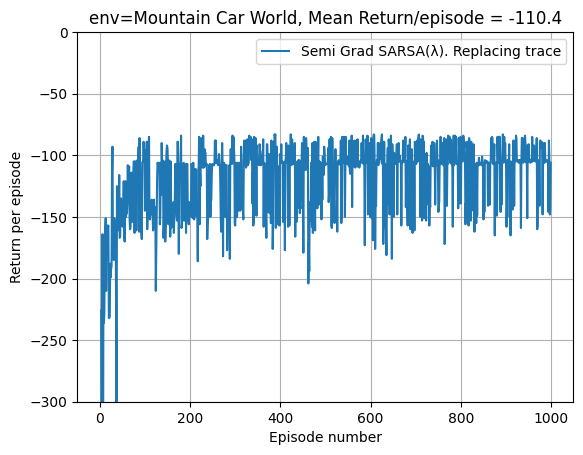

In [8]:
# create a n-SARSA Learning agent
step_size = 0.8
episode_cnt = 1000
epsilon= 0.0
gamma = 1.0
lambd = 0.5
env = gym.make('MountainCar-v0') 
##env._max_episode_steps = 500
np.random.seed(13)

## You can use of the two traces to see how they behave
## they will not have much difference in limit but behave differently to the parameters step_size, lambda 
## esp. in the early cycle of leraning. YOu can refer to Chapter 12 of Sutton and Barto book for a detailed
## explanation and derivation
#estimator = QEstimator(step_size, epsilon=epsilon, lambd = lambd, gamma=gamma, trace_fn=replacing_trace)
estimator = QEstimator(step_size, epsilon=epsilon, lambd = lambd, gamma=gamma, trace_fn=accumulating_trace)
rewards = sarsa_lambda(estimator, episode_cnt = episode_cnt, gamma=gamma)

#plot rewards
plot_rewards("Mountain Car World",rewards, 'Semi Grad SARSA(λ). Replacing trace')

### Watch Trained Agent

In [9]:
env_id = "MountainCar-v0"
video_folder = "logs/videos/lambda-sarsa/"
video_length = 500

agent = estimator
               
video_file = record_video(env_id, video_folder, video_length, agent)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/lambda-sarsa/QEstimator-MountainCar-v0-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/lambda-sarsa/QEstimator-MountainCar-v0-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/lambda-sarsa/QEstimator-MountainCar-v0-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/lambda-sarsa/QEstimator-MountainCar-v0-step-0-to-step-500.mp4


In [10]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Close Environment

In [11]:
env.close()